In [1]:
using NPZ
using Statistics
using PyPlot
using Flux
using Flux: mse
using Random
using Base.Iterators: partition
using BSON

In [2]:
mutable struct GaussianProcessDataset
    gp
    images
    labels
    transform
end

In [3]:
function initialize(gpd::GaussianProcessDataset, npz_file, rgb = false, only_len = false, only_sigma = false,
                log_sigma = false, transform=nothing)
    gpd.gp = npzread(npz_file)
    
    if rgb
        gpd.images = Float32.(gpd.gp["rgb_data"])
    else
        gpd.images = Float32.(gpd.gp["raw_data"])# size is (9000,32,32)
    end
    
    gpd.labels = Float32.(gpd.gp["label"]) # size is (9000,3)

    if log_sigma
        sig = Float32.(log.(10, gpd.labels[:,3]))
        gpd.labels[:,3] = sig
    end

    if only_len
        gpd.labels = gpd.labels[:,1:2]
    end
    if only_sigma
        gpd.labels = gpd.labels[:,3]
    end

    gpd.transform = transform
end

initialize (generic function with 6 methods)

In [4]:
function gpd_length(gpd::GaussianProcessDataset)
    return size(gpd.images)[1]
end

gpd_length (generic function with 1 method)

In [5]:
function getItem(gpd::GaussianProcessDataset, idx)
    image = gpd.images[idx,:,:]
    labels = gpd.labels[idx,:]
    
    image = reshape(image, (size(image)[1], size(image)[2], 1)) # [height x width, channel]

    # image: W x H x C
    image = permutedims(image, [1,2,3])  #delete once we validate that permutation is correct as is   

    return Dict("image"=>image, "label"=> labels)
end

getItem (generic function with 1 method)

In [ ]:
rgb = false; only_len = false; only_sigma = false; log_sigma = false;
gp_transformed_dataset_centered = GaussianProcessDataset(nothing, nothing, nothing, nothing)
initialize(gp_transformed_dataset_centered, "dataSimML_32.npz", rgb, only_len, only_sigma, log_sigma) #, false, false, false, false, nothing

println("Length of this data set is: " , gpd_length(gp_transformed_dataset_centered))

In [ ]:
println(getItem(gp_transformed_dataset_centered, 5102)["label"])

In [ ]:
img = Float32.(getItem(gp_transformed_dataset_centered, 5102)["image"])
label = getItem(gp_transformed_dataset_centered, 5102)["label"]
size(img)

In [ ]:
println(typeof(img), typeof(label))

In [6]:
function basicCNNRegressor(in_channels=1, out_dims=3)
    return Chain(
        
    # 1 x H x W => 32 x H x W
    Conv((3, 3), in_channels=>32, pad=(1,1), relu),
    # 32 x H x W => 32 x H/2 x W/2
    MaxPool((2,2)),

    # 32 x H/2 x W/2 => 16 x H/2 x W/2
    Conv((3, 3), 32=>16, pad=(1,1), relu),
    # 16 x H/2 x W/2 => 16 x H/4 x W/24
    MaxPool((2,2)),
        
    # 16 x H/4 x W/4 => 8 x H/4 x W/4
    Conv((3, 3), 16=>8, pad=(1,1)),
    # 8 x H/4 x H/4 => 8 x H/4 x H/4
    BatchNorm(8, relu),
    # 8 x H/4 x H/4 => 8 x H/8 x W/8
    MaxPool((2,2)),

    # 1 X 128
    flatten,
    Dropout(0.5),
    Dense(8*4*4, 10), #relu
    Dense(10, out_dims)
       
    )
end

basicCNNRegressor (generic function with 3 methods)

In [7]:
model = basicCNNRegressor(1, 3);

In [8]:
length(params(model))

12

In [9]:
#create a loss function
function loss_fn(x, y, model) 
    ŷ = model(x)
    return mse(ŷ, y)
end

loss_fn (generic function with 1 method)

In [10]:
mutable struct TrainValidationSampler
    data_size
    random_seed
    val_split
    shuffle
end

In [11]:
function callTVS(tvs::TrainValidationSampler)
    indices = Vector(1:tvs.data_size)
    split = Int(floor(tvs.val_split*tvs.data_size))
    
    if tvs.shuffle
        rng = MersenneTwister(tvs.random_seed)
        indices = shuffle(rng, indices)
    end
    
    val_indices = indices[1:split]
    
    train_indices = indices[split+1:tvs.data_size]
    
    return Dict("train_sampler"=>train_indices, "val_sampler"=> val_indices)
end

callTVS (generic function with 1 method)

In [12]:
function make_minibatch(X, Y, idxs)
    X_batch = Array{Float32}(undef, size(X[1])..., length(idxs));
    for i in 1:length(idxs)
        X_batch[:, :, :, i] = X[idxs[i]];
    end
    Y_batch = Array{Float32}(undef, size(Y[1])..., length(idxs))
    for i in 1:length(idxs)
        Y_batch[:,i] = Y[idxs[i]];
    end

    return (X_batch, Y_batch);
end

function get_data_loader(data_set,batch_size,sampler)
    reshapedImages = []
    labels = []
    for idx in 1:gpd_length(data_set)
        item =  getItem(data_set, idx)
        
        push!(reshapedImages,item["image"])
        push!(labels, item["label"])
    end
    
    selectedImages = [reshapedImages[i] for i in sampler]
    selectedLabels = [labels[i] for i in sampler]
    
    mb_idxs = partition(1:length(selectedImages), batch_size);
    data_set = [make_minibatch(selectedImages, selectedLabels, i) for i in mb_idxs];
    return data_set
end

get_data_loader (generic function with 1 method)

In [ ]:
function train(n_epochs, optimizer, loss_func, train_loader, val_loader)
    
    nn_model = basicCNNRegressor()
    
    function loss_fn(x, y) 
        ŷ = nn_model(x)
        return mse(ŷ,y)
    end
    
    epoch_loss_list = []
    epoch_val_loss_list = []
    for epoch in 1:n_epochs
        loss_list = []
        val_loss_list = []
        println("Epoch ", epoch); flush(stdout)
        Flux.train!(loss_fn, params(nn_model), train_loader, optimizer)

        for data in train_loader
            img = data[1]
            labels = data[2]
            loss = loss_fn(img, labels)
            append!(loss_list, loss)
        end

        # Do validation
        for data_v in val_loader
            img = data_v[1]
            labels = data_v[2]
            loss = loss_fn(img, labels)
            append!(val_loss_list, loss)
        end

        println(mean(loss_list), " ", mean(val_loss_list))
        append!(epoch_loss_list, mean(loss_list))
        append!(epoch_val_loss_list, mean(val_loss_list))
        
    end
    return epoch_loss_list, epoch_val_loss_list, nn_model
end

In [ ]:
batch_size = 30
n_epochs = 150
learning_rate = 1e-3
# optimizer = ADAM(learning_rate);
optimizer = Momentum(learning_rate, 0.9);

sampler = TrainValidationSampler(gpd_length(gp_transformed_dataset_centered), 42, 0.2, true)
split_sample = callTVS(sampler);

train_loader = get_data_loader(gp_transformed_dataset_centered, batch_size, split_sample["train_sampler"]);
val_loader = get_data_loader(gp_transformed_dataset_centered, batch_size, split_sample["val_sampler"]);

In [ ]:
losses,losses_v, nn_model = train(n_epochs, optimizer, loss_fn, train_loader, val_loader)

In [ ]:
using BSON: @save
@save "mymodel_06_2021.bson" nn_model

In [ ]:
x = 1:batch_size
y = losses
z = losses_v
plot(y)
plot(z)

Length of this data set is: 395
(395, 32, 32)


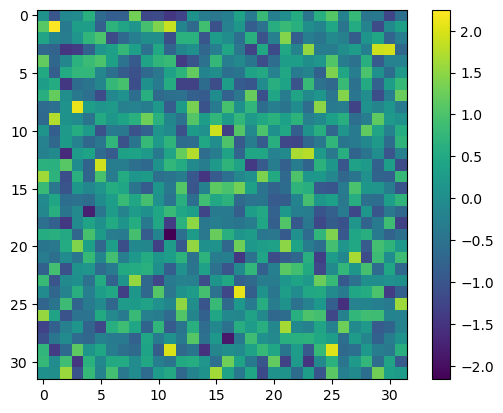

In [21]:
using BenchmarkTools
#to test synthetic data 3 plots

rgb = false; only_len = false; only_sigma = false; log_sigma = false;
gp_ml = GaussianProcessDataset(nothing, nothing, nothing, nothing)
#initialize(gp_ml, "dataML_1.npz", rgb, only_len, only_sigma, log_sigma) #, false, false, false, false, nothing
initialize(gp_ml, "Data2/dataML_data2.npz", rgb, only_len, only_sigma, log_sigma) #, false, false, false, false, nothing

println("Length of this data set is: " , gpd_length(gp_ml))

println(size(gp_ml.images))

im = reshape(gp_ml.images[1:1024], 32,32)
using PyPlot

imshow((im),interpolation="none")
colorbar()

sampler2 = TrainValidationSampler(gpd_length(gp_ml), 42, 1, true)
split_sample2 = callTVS(sampler2);

val_data = get_data_loader(gp_ml, gpd_length(gp_ml), split_sample2["val_sampler"]);

using BSON: @load

# labels = val_data[1][2]

@load "mymodel_06_2021.bson" nn_model

outputs = nn_model(val_data[1][1]);

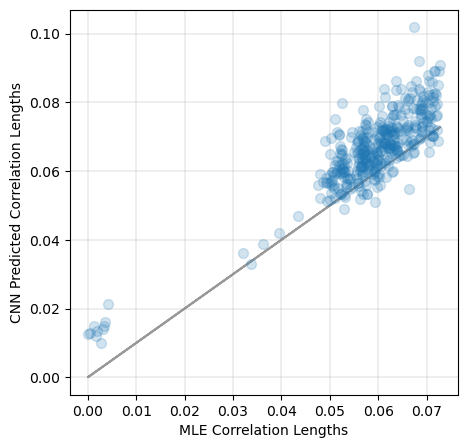

In [24]:
using Base.MathConstants
x0 =  val_data[1][2][1,:]
x0 = 10 .^ (log10.(exp.(x0)))
y0 = 10 .^ outputs[1,:]

fig = figure("pyplot_scatterplot",figsize=(5,5))
plot(x0,x0,color=(.5,.5,.5), alpha=0.8, zorder=1)

ax = PyPlot.axes()
ax.grid(linewidth=0.3)
grid("on")
ax.set_axisbelow(true)

PyPlot.scatter(x0,y0,s=50,alpha=0.2, zorder=2)
xlabel("MLE Correlation Lengths")
ylabel("CNN Predicted Correlation Lengths")
savefig("corlat.png")